In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

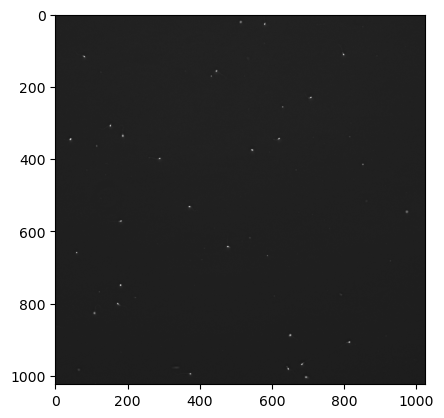

In [2]:
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

### Feed through the tracking pipeline

In [12]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

Frame 263: 30 trajectories present.
            y           x         mass      size       ecc      signal  \
0   21.647677  513.689746  1398.373408  2.240766  0.016136   66.180687   
1  995.430677  374.188392  1330.354368  1.747275  0.229076  120.105691   
2  968.695179  683.105835  1690.671443  1.964989  0.293751  129.910238   
3  749.847249  181.090939  1893.502993  1.732705  0.078447  156.259956   
4  659.850138   59.543802  1112.203214  1.627247  0.139895  110.913929   

   raw_mass        ep  frame  sperm  
0    5739.0  0.007017      0      0  
1    4806.0  0.009882      0      2  
2    5649.0  0.007219      0      4  
3    5916.0  0.006652      0      8  
4    4344.0  0.012386      0      9  


In [13]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

            y           x         mass      size       ecc      signal  \
0   21.647677  513.689746  1398.373408  2.240766  0.016136   66.180687   
1  995.430677  374.188392  1330.354368  1.747275  0.229076  120.105691   
2  968.695179  683.105835  1690.671443  1.964989  0.293751  129.910238   
3  749.847249  181.090939  1893.502993  1.732705  0.078447  156.259956   
4  659.850138   59.543802  1112.203214  1.627247  0.139895  110.913929   

   raw_mass        ep  frame  sperm  
0    5739.0  0.007017      0      0  
1    4806.0  0.009882      0      2  
2    5649.0  0.007219      0      4  
3    5916.0  0.006652      0      8  
4    4344.0  0.012386      0      9  


In [14]:
utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="segments")

# Run Metrics

In [3]:
prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"

#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"

#prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"

# Load as Pandas DataFrame
pred = utils.loadDataFrame(prediction)
gt = utils.loadDataFrame(groundtruth)


### Unlabeled Metrics

### Labeled Metrics

In [23]:
from  scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

# Use Hungarian Algorithm to find best track matches between pred and gt in each frame
labels_ref = []
labels_comp = []
mapped_ref = []
mapped_comp = []

# For each frame
for f in range(0, pred['frame'].max() + 1):

    mapped_ref_frame = []
    mapped_comp_frame = []

    # Get the labels in the frame
    labels_ref_frame = gt[gt['frame'] == f]['sperm'].values
    labels_comp_frame = pred[pred['frame'] == f]['sperm'].values

    # Get the centroids in the frame
    ref_centroids = gt[gt['frame'] == f][['x', 'y']].values
    comp_centroids = pred[pred['frame'] == f][['x', 'y']].values

    # Compute the distance matrix
    dist_matrix = cdist(ref_centroids, comp_centroids)

    #import matplotlib.pyplot as plt
    #plt.imshow(dist_matrix);plt.show()
    #print(np.amin(dist_matrix))

    # Use Hungarian Algorithm to find best matches
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    #for r, c in zip(row_ind, col_ind):
    #    print(r,c)

    # Save the matches
    for r, c in zip(row_ind, col_ind):
        mapped_ref_frame.append(labels_ref_frame[r])
        mapped_comp_frame.append(labels_comp_frame[c])
    
        #labels_ref_frame.append(ref_labels[r])
        #labels_comp_frame.append(comp_labels[c])
        #mapped_ref_frame.append(gt[(gt['frame'] == f) & (gt['sperm'] == ref_labels[r])]['sperm'].values[0])
        #mapped_comp_frame.append(pred[(pred['frame'] == f) & (pred['sperm'] == comp_labels[c])]['sperm'].values[0])

    labels_ref.append(labels_ref_frame)
    labels_comp.append(labels_comp_frame)
    mapped_ref.append(mapped_ref_frame)
    mapped_comp.append(mapped_comp_frame)

traj = {}
traj['labels_ref'] = labels_ref
traj['labels_comp'] = labels_comp
traj['mapped_ref'] = mapped_ref
traj['mapped_comp'] = mapped_comp

#print(labels_ref)
#print(labels_comp)
#print(mapped_ref)
#print(mapped_comp)

In [27]:
# Create track data needed for calculation (Label, Birth Frame, Death Frame, 0 (no parent))

ref_tracks = []

for s in range(0, gt['sperm'].max() + 1):
    cur_frames = gt[gt['sperm'] == s]['frame'].values
    if len(cur_frames) > 0:
        cur_birth = np.amin(cur_frames)
        cur_death = np.amax(cur_frames)
        cur_parent = 0
        cur_track = [s, cur_birth, cur_death, cur_parent]
        ref_tracks.append(cur_track)

ref_tracks = np.array(ref_tracks)

comp_tracks = []

for s in range(0, pred['sperm'].max() + 1):
    cur_frames = pred[pred['sperm'] == s]['frame'].values
    if len(cur_frames) > 0:
        cur_birth = np.amin(cur_frames)
        cur_death = np.amax(cur_frames)
        cur_parent = 0
        cur_track = [s, cur_birth, cur_death, cur_parent]
        comp_tracks.append(cur_track)

comp_tracks = np.array(comp_tracks)


(116, 4)


In [ ]:
from ctc_metrics.utils.representations import merge_tracks, count_acyclic_graph_correction_operations

new_tracks, new_labels, new_mapped = merge_tracks(
    ref_tracks, traj["labels_ref"], traj["mapped_ref"])
traj["ref_tracks_merged"] = new_tracks
traj["labels_ref_merged"] = new_labels
traj["mapped_ref_merged"] = new_mapped
new_tracks, new_labels, new_mapped = merge_tracks(
    comp_tracks, traj["labels_comp"], traj["mapped_comp"])
traj["comp_tracks_merged"] = new_tracks
traj["labels_comp_merged"] = new_labels
traj["mapped_comp_merged"] = new_mapped

graph_operations = \
            count_acyclic_graph_correction_operations(
                ref_tracks, comp_tracks,
                traj["labels_ref"], traj["labels_comp"],
                traj["mapped_ref"], traj["mapped_comp"]
            )

print(graph_operations)

{'num_vertices_R': 12706, 'num_vertices_C': 12034, 'num_vertices': 12706, 'TP': 11986, 'FN': 720, 'FP': 48, 'VS': 0, 'NS': 0, 'ED': 10401, 'EA': 11235, 'EC': 0, 'num_edges': 12598}


In [30]:
from ctc_metrics.metrics import (
    valid, det, seg, tra, ct, tf, bc, cca, mota, hota, idf1, chota, mtml, faf,
    op_ctb, op_csb, bio, op_clb, lnk
)

results = {}
results["DET"] = det(**graph_operations)
_tra, _aogm, _aogm0 = tra(**graph_operations)
results["TRA"] = _tra
results["AOGM"] = _aogm
results["AOGM_0"] = _aogm0
for key in ("NS", "FN", "FP", "ED", "EA", "EC"):
    results[f"AOGM_{key}"] = graph_operations[key]

results["LNK"] = lnk(**graph_operations)

results["CT"] = ct(
            comp_tracks, ref_tracks,
            traj["labels_ref"], traj["mapped_ref"], traj["mapped_comp"])

results["TF"] = tf(
    ref_tracks,
    traj["labels_ref"], traj["mapped_ref"], traj["mapped_comp"])


results.update(mota(
    traj["labels_ref_merged"], traj["labels_comp_merged"],
    traj["mapped_ref_merged"], traj["mapped_comp_merged"]))

results.update(hota(
    traj["labels_ref_merged"], traj["labels_comp_merged"],
    traj["mapped_ref_merged"], traj["mapped_comp_merged"]))

results.update(idf1(
    traj["labels_ref_merged"], traj["labels_comp_merged"],
    traj["mapped_ref_merged"], traj["mapped_comp_merged"]))


In [32]:
for key,val in results.items():
    print(key, val)

DET 0.9429560837399654
TRA 0.7636187370252883
AOGM 34501.5
AOGM_0 145957.0
AOGM_NS 0
AOGM_FN 720
AOGM_FP 48
AOGM_ED 10401
AOGM_EA 11235
AOGM_EC 0
LNK 0.0
CT 0.12244897959183673
TF 0.5102127740552326
